In [1]:
import sys
from pathlib import Path

# Assume `src` is located relative to the current working directory
src_path = Path.cwd().parent / 'src'

# Add the `src` directory to sys.path
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))


In [2]:
import numpy as np
np.random.seed(42)

In [3]:
from stages.collect_classification_stats import classifier_experiment_run

In [4]:
from datetime import datetime

from classifying import (
    ActivationsHandler,
    get_correctness_direction_classifier,
    get_logistic_regression_classifier,
)


In [5]:
stats_res = classifier_experiment_run(
    run_config=[("llama3_8b", "cities_augmented", 12)],
)
stats_res

/Users/anton/dev/MARS/correctness-model-internals/src/stages/collect_classification_stats.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt.load(p)
/Users/anton/dev/MA

{'check_correctness_classifier': True,
 'check_logistic_regression_classifier': True,
 'timestamp': '2025-01-25 15:39:30.424471',
 'notes': '',
 'results': {('llama3_8b',
   'cities_augmented',
   'layer_12'): {'fold_0': {'n_train': 765,
    'n_test': 191,
    'correctness_direction_classifier': {'optimal_cut': 2.7186060112055,
     'optimal_train_set_cut': 2.7186060112055,
     'test_roc_auc': 0.88059043842256,
     'accuracy_score': 0.8010471204188482,
     'f1_score': 0.7764705882352941},
    'activation_space_directions': {'classifying_direction': [-0.3773916470427643,
      0.09477823266683644,
      -0.10732267575045523,
      0.12281668549317235,
      0.10981656165178388,
      -0.09139453417952126,
      -0.3718996965460707,
      -0.1220332551399973,
      -0.8092800781535674,
      0.3187828341219034,
      -0.5049698410457861,
      -0.09270804551360573,
      -0.15947180073155137,
      -0.6229161620615526,
      -0.20766654649609495,
      -0.3250335595829948,
      -0.36

In [8]:
stats_res["results"][("llama3_8b", "cities_augmented", "layer_12")]["fold_0"]

{'n_train': 765,
 'n_test': 191,
 'correctness_direction_classifier': {'optimal_cut': 2.7186060112055,
  'optimal_train_set_cut': 2.7186060112055,
  'test_roc_auc': 0.88059043842256,
  'accuracy_score': 0.8010471204188482,
  'f1_score': 0.7764705882352941},
 'activation_space_directions': {'classifying_direction': [-0.3773916470427643,
   0.09477823266683644,
   -0.10732267575045523,
   0.12281668549317235,
   0.10981656165178388,
   -0.09139453417952126,
   -0.3718996965460707,
   -0.1220332551399973,
   -0.8092800781535674,
   0.3187828341219034,
   -0.5049698410457861,
   -0.09270804551360573,
   -0.15947180073155137,
   -0.6229161620615526,
   -0.20766654649609495,
   -0.3250335595829948,
   -0.36436396600134596,
   -0.1622781142014888,
   -0.20149064069364925,
   0.12491012146298158,
   -0.10320938723544047,
   0.5039064500330592,
   -0.8975403749865494,
   -0.026292022847497258,
   -0.3997885418062327,
   -0.2897546244097685,
   -0.313056754342772,
   -0.4278768600257804,
   -0.1

In [6]:
def deleteme_dummy_file_loader():
    from pathlib import Path

    import pandas as pd
    import torch as pt

    return pd.read_csv(
        "/Users/anton/dev/MARS/correctness-model-internals/deleteme/labels/labels.csv"
    ), pt.cat(
        [
            pt.load(p) for p in 
            sorted([p for p in Path(
                "/Users/anton/dev/MARS/correctness-model-internals/deleteme/acts/llama3_8b/dummy_dataset/"
            ).iterdir()], key=lambda p: int(str(p).split("_")[-1].split(".")[0]))
        ],
        axis=0,
    )

labels_df, activations = deleteme_dummy_file_loader()

/var/folders/qd/cz9h19sd335142892r1531f40000gn/T/ipykernel_55032/3320563134.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt.load(p) for p in


In [7]:
activations

tensor([[ 93.0591, 104.6248,  93.0795,  ..., 116.1191,  76.9093, 111.3390],
        [ 94.7694,  90.8964,  97.9689,  ...,  99.7145,  93.2711, 103.7654],
        [ 72.7132,  92.9954, 103.7981,  ..., 121.4035,  78.6195, 114.4310],
        ...,
        [ 80.2254,  88.0465, 121.3476,  ...,  89.8563,  77.9289, 124.7970],
        [ 64.7791,  89.8161, 114.2226,  ..., 111.8732,  80.5566, 112.1016],
        [ 84.2600,  95.3131, 113.8737,  ...,  98.7084,  78.3669,  90.0117]],
       dtype=torch.float64)

In [8]:
labels_df["correct"]

0      False
1       True
2      False
3       True
4      False
       ...  
995    False
996     True
997    False
998    False
999    False
Name: correct, Length: 1000, dtype: bool

In [9]:
# labels_df.loc[::10, "correct"] = "IDK"
labels_df.loc[::10, "correct"] = "IDK"
# labels_df = labels_df[labels_df["correct"] != "IDK"]
labels_df

/var/folders/qd/cz9h19sd335142892r1531f40000gn/T/ipykernel_55032/2911788035.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IDK' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  labels_df.loc[::10, "correct"] = "IDK"


,Unnamed: 0,correct
0,0,IDK
1,1,True
2,2,False
3,3,True
4,4,False
...,...,...
995,995,False
996,996,True
997,997,False
998,998,False


In [10]:
activation_handler = ActivationsHandler(
    activations=activations, labels=labels_df["correct"].astype(bool)
)
activation_handler.labels


0       True
1       True
2      False
3       True
4      False
       ...  
995    False
996     True
997    False
998    False
999    False
Name: correct, Length: 1000, dtype: bool

In [11]:
activation_handler = activation_handler.sample_equally_across_groups(
    group_labels=[False, True]
)
activation_handler.activations.shape


torch.Size([934, 4096])

In [12]:
activations_handler_train, activations_handler_test = (
    activation_handler.split_dataset(split_sizes=[0.8, 0.2])
)

activations_handler_test.labels

0      False
1      False
2       True
3       True
4      False
       ...  
182     True
183    False
184    False
185     True
186    False
Name: correct, Length: 187, dtype: bool

In [13]:
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from classifying import ActivationsHandler, BinaryClassifier, DirectionCalculator


def visualise_clusters_dimenstionality_reduction(
    activations_handler_train: ActivationsHandler,
    activations_handler_test: ActivationsHandler,
    direction_calculator: None | DirectionCalculator = None,
    experiment_path: None | Path | str = None,
):
    pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2))
    pca_pipeline.fit(activations_handler_train.activations)
    pca_activations_test = pca_pipeline.transform(activations_handler_test.activations)

    ax = sns.scatterplot(
        x=pca_activations_test[:, 0],
        y=pca_activations_test[:, 1],
        hue=activations_handler_test.labels,
    )

    if direction_calculator is not None:
        correctness_end_pca = pca_pipeline.transform(
            direction_calculator.classifying_direction[None, :]
        ).squeeze()

        zero_pca = pca_pipeline.transform(
            [[0] * activations_handler_train.activations.shape[1]]
        ).squeeze()

        correctness_direction_pca = (
            correctness_end_pca - zero_pca
        )  # need to transform the begining and end of the vector so that we transform the vector so that we can get the difference in pca space.
        ax.quiver(
            0,
            0,
            correctness_direction_pca[0],
            correctness_direction_pca[1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="red",
            label="Correctness Direction",
        )

    ax.legend()
    plt.tight_layout()
    if experiment_path:
        plt.savefig(experiment_path / "pca.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()
    plt.clf()

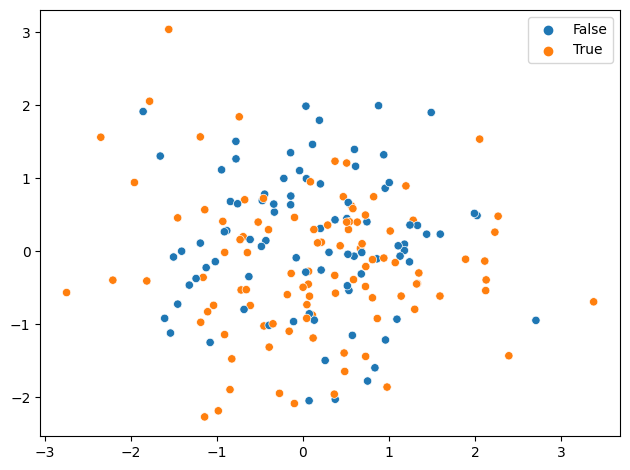

<Figure size 640x480 with 0 Axes>

In [14]:
visualise_clusters_dimenstionality_reduction(
    activations_handler_train,
    activations_handler_test,
)

In [15]:
activations_handler_train.labels = activations_handler_train.labels.astype(bool)
activations_handler_test.labels = activations_handler_test.labels.astype(bool)


In [16]:
def get_correctness_direction_classifier(
    activations_handler_train: ActivationsHandler,
    activations_handler_test: ActivationsHandler,
):
    direction_calculator = DirectionCalculator(
        activations_from=activations_handler_train.get_groups(
            False
        ).activations,
        activations_to=activations_handler_train.get_groups(True).activations,
    )
    direction_classifier = BinaryClassifier(
        train_labels=activations_handler_train.labels,
        train_classification_score=direction_calculator.get_distance_along_classifying_direction(
            activations_handler_train.activations
        ),
        test_labels=activations_handler_test.labels,
        test_classification_score=direction_calculator.get_distance_along_classifying_direction(
            activations_handler_test.activations
        ),
    )
    return direction_classifier, direction_calculator


direction_classifier, direction_calculator = get_correctness_direction_classifier(activations_handler_train, activations_handler_test)

In [17]:
direction_classifier.roc_auc

AttributeError: 'BinaryClassifier' object has no attribute 'roc_auc'

In [18]:
direction_classifier.classification_metrics

{'optimal_cut': -37.7806536035598,
 'optimal_train_set_cut': -37.7806536035598,
 'roc_auc': 0.8287577213452301,
 'accuracy_score': 0.7433155080213903,
 'f1_score': 0.7303370786516854}

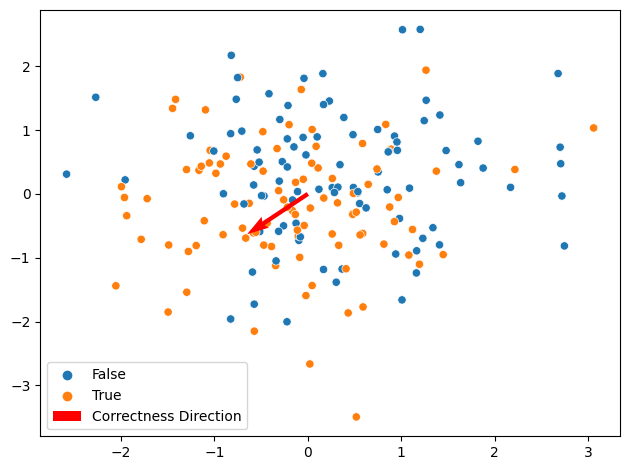

<Figure size 640x480 with 0 Axes>

In [19]:
visualise_clusters_dimenstionality_reduction(
    activations_handler_train,
    activations_handler_test,
    direction_calculator=direction_calculator,
)

In [20]:
def visualise_score(
    binary_classifier: BinaryClassifier,
    experiment_path: None | Path = None,
    extra_groups: None | dict[str, Any] = None,
):
    df = pd.DataFrame(
        {
            "label": binary_classifier.test_labels,
            "score": binary_classifier.test_classification_score,
        }
    )
    if extra_groups:
        if any(
            extra_group in df["label"].unique() for extra_group in extra_groups.keys()
        ):
            raise ValueError(
                "extra_groups can't have names of labels that already exist"
            )
        df = pd.concat(
            [df]
            + [
                pd.DataFrame({"label": group_name, "score": group})
                for group_name, group in extra_groups.items()
            ],
            axis=0,
        )

    print(f"{df.describe()=}")
    print(f"{df.head()=}")

    optimal_cut = binary_classifier.optimal_cut
    acc = binary_classifier.classification_metrics["accuracy_score"]
    f1 = binary_classifier.classification_metrics["f1_score"]

    # Create the plot with multiple categories but shared bins
    bin_edges = np.histogram_bin_edges(df["score"], bins=100)
    ax = sns.histplot(
        data=df,
        x=df["score"],
        bins=bin_edges,
        hue=df["label"],
    )

    # Add the threshold line
    optimal_cut_label = f"Optimal Threshold {optimal_cut:.3f}"
    ax.axvline(optimal_cut, color="red", linestyle="--", label=optimal_cut_label)

    # Create the new legend with all elements
    ax.legend()
    ax.set_title(f"Classification. Accuracy={acc:.3f}, F1={f1:.3f}")
    plt.tight_layout()
    if experiment_path:
        plt.savefig(
            experiment_path / "classifier_separation.png", dpi=300, bbox_inches="tight"
        )
    else:
        plt.show()
    plt.clf()


In [21]:
activation_handler2 = ActivationsHandler(
    activations=activations, labels=labels_df["correct"]
)
activation_handler2.get_groups("IDK")

In [22]:
idk_directions = direction_calculator.get_distance_along_classifying_direction(activation_handler2.get_groups("IDK").activations)
idk_directions

tensor([ 380.1951,  973.5900, 1022.3489,  350.8489,  252.6720,   91.7826,
         304.7420,  487.1852,   55.7767, -463.7724,  564.5661, 1120.7735,
        1144.2514,  947.6050,  217.3810,  498.5962,    6.2331,  262.0127,
         939.6831,   -8.2465, -198.8706,  218.0007,  261.8101,  144.8730,
        1049.2216, -199.7475, -371.4729, -421.3706, 1144.4256, 1278.8437,
        1117.0810,  158.6042,  715.7329,   76.2986,  188.8883, -180.2529,
         865.9979, -108.7538,  761.1038,  280.8952,  330.8073,  426.6202,
         -37.7807,  316.5670,  133.3024,  -16.9254, -242.0716,  233.6589,
        1170.5032,  934.9908,  965.7204,   10.5985,  464.7992,  753.1109,
        -426.7266,  450.4516,  989.4788,  319.6881,   35.1784,  678.3075,
        -592.4841,   26.7289,  111.5646,  281.4710,  309.9971,  474.9380,
         996.3861,  -54.4334, 1023.7546, -175.0484, -374.4824, 1206.1906,
         663.7784, 1012.1176, -134.0300,  235.9222,  229.0212, -635.0721,
         400.0751,   84.5725, -209.039

df.describe()=             score
count   287.000000
mean     72.224049
std     439.563341
min    -785.704274
25%    -240.290620
50%      48.623131
75%     321.553432
max    1278.843699
df.head()=   label       score
0  False   84.533749
1   True -374.482413
2  False -130.653470
3  False -238.509653
4  False -150.085083


/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/anton/dev/.vir

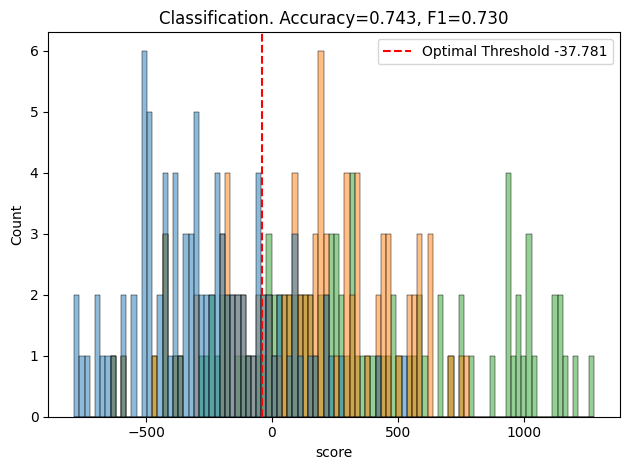

<Figure size 640x480 with 0 Axes>

In [23]:
visualise_score(direction_classifier, extra_groups={"IDK": idk_directions})

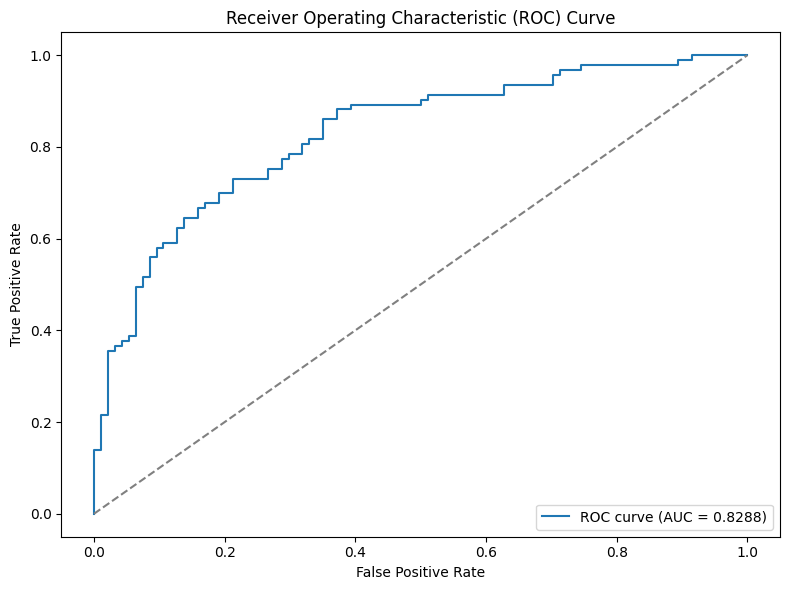

<Figure size 640x480 with 0 Axes>

In [24]:

def visualise_roc(binary_classifier, experiment_path: None | Path = None):
    plt.figure(figsize=(8, 6))
    plt.plot(
        binary_classifier.test_false_positive_rate,
        binary_classifier.test_true_positive_rate,
        label=f"ROC curve (AUC = {binary_classifier.roc_auc:.4f})",
    )

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()

    if experiment_path:
        plt.savefig(
            experiment_path / "classifier_roc.png", dpi=300, bbox_inches="tight"
        )
    else:
        plt.show()
    plt.clf()

visualise_roc(direction_classifier)

In [25]:
import argparse
import json
from datetime import datetime
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch as pt
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, f1_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from classifying.activations_handler import ActivationsHandler
from classifying.direction_calculator import DirectionCalculator


def get_logistic_regression_classifier(
    activations_handler_train: ActivationsHandler,
    activations_handler_test: ActivationsHandler,
):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(activations_handler_train.activations)
    X_test = scaler.transform(activations_handler_test.activations)

    model = LogisticRegression(
        random_state=42, solver="lbfgs", max_iter=1000, class_weight="balanced"
    )
    model.fit(X_train, activations_handler_train.labels)

    logistic_regression_classifier = BinaryClassifier(
        train_labels=activations_handler_train.labels,
        train_classification_score=model.predict_proba(X_train)[:, 1],
        test_labels=activations_handler_test.labels,
        test_classification_score=model.predict_proba(X_test)[:, 1],
        classification_cut=0.5,
    )
    return logistic_regression_classifier, model

logistic_regression_classifier, model = get_logistic_regression_classifier(activations_handler_train, activations_handler_test)

In [26]:
logistic_regression_classifier.classification_metrics

{'optimal_cut': 0.5,
 'optimal_train_set_cut': 0.9960516579478349,
 'roc_auc': 0.7966140471288035,
 'accuracy_score': 0.7165775401069518,
 'f1_score': 0.6971428571428572}

df.describe()=            score
count  187.000000
mean     0.446927
std      0.382473
min      0.000623
25%      0.055200
50%      0.411470
75%      0.865633
max      0.999467
df.head()=   label     score
0  False  0.773278
1   True  0.070944
2  False  0.171757
3  False  0.454777
4  False  0.026777


/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


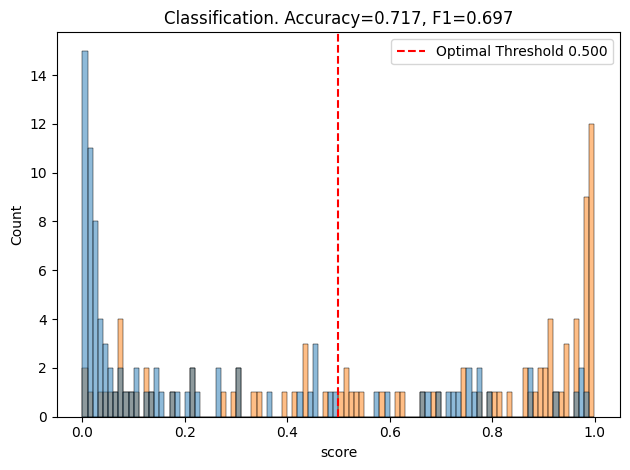

<Figure size 640x480 with 0 Axes>

In [27]:
visualise_score(logistic_regression_classifier)

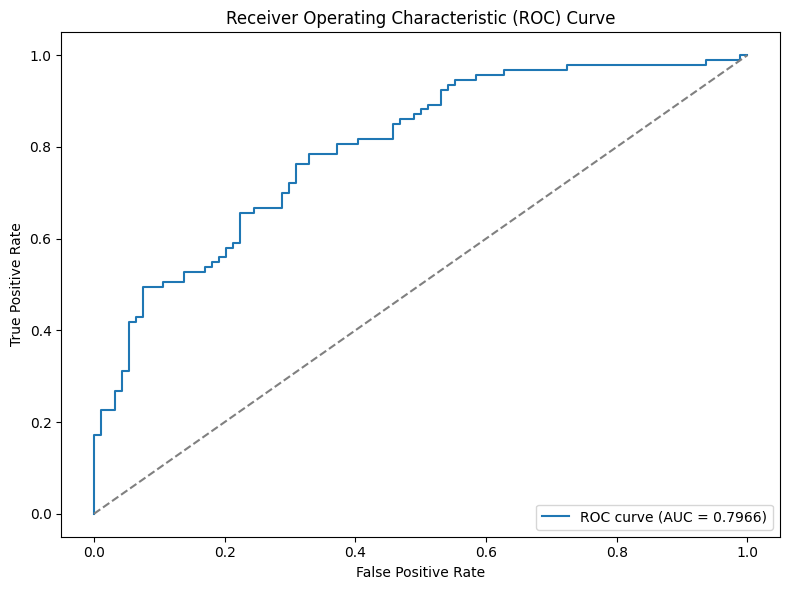

<Figure size 640x480 with 0 Axes>

In [28]:
visualise_roc(logistic_regression_classifier)

In [29]:
activation_handler.labels

0      False
1      False
2      False
3      False
4      False
       ...  
929     True
930     True
931     True
932     True
933     True
Name: correct, Length: 934, dtype: bool

In [76]:
activations_handler_folds = list(
    activation_handler.split_dataset(split_sizes=[0.2]*5)
)
activations_handler_folds

In [77]:
# directions = []
for i, activations_handler_test_ in enumerate(activations_handler_folds):
    activations_handler_train_ = ActivationsHandler(activations=pt.cat([a.activations for j, a in enumerate(activations_handler_folds) if j != i], axis=0), labels=pd.concat([a.labels for j, a in enumerate(activations_handler_folds) if j != i], axis=0).reset_index(drop=True))
    direction_classifier, direction_calculator = get_correctness_direction_classifier(activations_handler_train_, activations_handler_test_)
    print(f"{direction_classifier.classification_metrics=}")
    # directions.append(direction_calculator.classifying_direction)

direction_classifier.classification_metrics={'optimal_cut': -166.15090526538876, 'optimal_train_set_cut': -166.15090526538876, 'roc_auc': 0.8196283391405342, 'accuracy_score': 0.7165775401069518, 'f1_score': 0.774468085106383}
direction_classifier.classification_metrics={'optimal_cut': -118.34488613818623, 'optimal_train_set_cut': -118.34488613818623, 'roc_auc': 0.8475665748393021, 'accuracy_score': 0.7379679144385026, 'f1_score': 0.776255707762557}
direction_classifier.classification_metrics={'optimal_cut': -104.98590412922529, 'optimal_train_set_cut': -104.98590412922529, 'roc_auc': 0.8197449994151362, 'accuracy_score': 0.7096774193548387, 'f1_score': 0.7157894736842105}
direction_classifier.classification_metrics={'optimal_cut': -75.50242991760044, 'optimal_train_set_cut': -75.50242991760044, 'roc_auc': 0.8647099289153863, 'accuracy_score': 0.7807486631016043, 'f1_score': 0.8019323671497585}
direction_classifier.classification_metrics={'optimal_cut': -41.230634774227156, 'optimal_tr

In [102]:
activations_handler_train_.get_groups(labels=[True])

In [115]:
pd.Series((activation_handler.get_groups(labels=[True]).activations ** 2).sum(axis=1)**0.5).describe()


count     467.000000
mean     6473.922218
std        14.320204
min      6443.262800
25%      6464.716263
50%      6471.673653
75%      6480.945153
max      6526.845603
dtype: float64

In [116]:
pd.Series((activation_handler.get_groups(labels=[False]).activations ** 2).sum(axis=1)**0.5).describe()

count     467.000000
mean     6502.903364
std         9.616636
min      6472.438157
25%      6496.453735
50%      6502.786918
75%      6509.093216
max      6532.797488
dtype: float64

In [103]:
directions = []
for i, activations_handler_train_ in enumerate(activations_handler_folds):
    # activations_handler_train_ = ActivationsHandler(activations=pt.cat([a.activations for j, a in enumerate(activations_handler_folds) if j != i], axis=0), labels=pd.concat([a.labels for j, a in enumerate(activations_handler_folds) if j != i], axis=0).reset_index(drop=True))
    direction_calculator = DirectionCalculator(
        activations_from=activations_handler_train_.get_groups(
            False
        ).activations,
        activations_to=activations_handler_train_.get_groups(True).activations,
    )
    directions.append(direction_calculator.classifying_direction)

ValueError: False is not a valid label

In [93]:
import torch.nn.functional as F

# directions_normalised = [(direction / (direction ** 2).sum()**0.5) for direction in directions]
print([((direction ** 2).sum()**0.5).item() for direction in directions])
for i, direction1 in enumerate(directions):
    for j, direction2 in enumerate(directions):
        if i == j:
            continue
        print(i, j)
        print("cosine_similarity", F.cosine_similarity(direction1, direction2, dim=0).item())
        print("dot_product", pt.dot(direction1, direction2).item())

[]


In [80]:
random_directions = [pt.from_numpy(np.random.normal(0, 100, 4096)) for _ in range(5)]

random_directions_normalised = [(direction / (direction ** 2).sum()**0.5) for direction in random_directions]
for i, direction1 in enumerate(random_directions_normalised):
    for j, direction2 in enumerate(random_directions_normalised):
        if i == j:
            continue
        print(i, j)
        print(F.cosine_similarity(direction1, direction2, dim=0))

0 1
tensor(-0.0030, dtype=torch.float64)
0 2
tensor(-0.0141, dtype=torch.float64)
0 3
tensor(0.0084, dtype=torch.float64)
0 4
tensor(0.0012, dtype=torch.float64)
1 0
tensor(-0.0030, dtype=torch.float64)
1 2
tensor(0.0072, dtype=torch.float64)
1 3
tensor(-0.0011, dtype=torch.float64)
1 4
tensor(0.0053, dtype=torch.float64)
2 0
tensor(-0.0141, dtype=torch.float64)
2 1
tensor(0.0072, dtype=torch.float64)
2 3
tensor(-0.0100, dtype=torch.float64)
2 4
tensor(-0.0105, dtype=torch.float64)
3 0
tensor(0.0084, dtype=torch.float64)
3 1
tensor(-0.0011, dtype=torch.float64)
3 2
tensor(-0.0100, dtype=torch.float64)
3 4
tensor(-0.0187, dtype=torch.float64)
4 0
tensor(0.0012, dtype=torch.float64)
4 1
tensor(0.0053, dtype=torch.float64)
4 2
tensor(-0.0105, dtype=torch.float64)
4 3
tensor(-0.0187, dtype=torch.float64)


In [74]:
F.cosine_similarity(
    pt.from_numpy(np.random.normal(0, 100, 4096)),
    pt.from_numpy(np.random.normal(0, 100, 4096)),
    dim=-1
)

tensor(0.0116, dtype=torch.float64)

In [134]:
list(activation_handler.split_dataset(splits=[0]))[0].labels.sum()

ValueError: Splits must be positive numbers.

In [126]:
activation_handler.labels

0      False
1      False
2      False
3      False
4      False
       ...  
929     True
930     True
931     True
932     True
933     True
Name: correct, Length: 934, dtype: bool